In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
from joblib import Parallel, delayed

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [2]:
df_train = utils.read_df_pkl('../input/train0*')
df_test = utils.read_df_pkl('../input/test0*')
df_train.set_index(key, inplace=True)
df_test.set_index(key, inplace=True)
train_test = pd.concat([df_train, df_test], axis=0)
df_hist = utils.read_df_pkl('../input/hist_clean*')
df_new = utils.read_df_pkl('../input/new_clean*')

df_train = utils.reduce_mem_usage(df_train)
df_test  = utils.reduce_mem_usage(df_test )
df_hist  = utils.reduce_mem_usage(df_hist )
df_new   = utils.reduce_mem_usage(df_new  )

100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 2554.26 Mb (0.0% reduction)
Mem. usage decreased to 183.47 Mb (0.0% reduction)


In [3]:
from time_utils import date_add_days

hist_max_date = df_hist.groupby(key)['purchase_date'].max()
hist_min_date = df_hist.groupby(key)['purchase_date'].min()
hist_max_date.name = 'hist_purchase_date_max'
hist_min_date.name = 'hist_purchase_date_min'
hist_max_date = hist_max_date.to_frame()
hist_min_date = hist_min_date.to_frame()

# month_maxは翌月の数字にする
hist_max_date['hist_purchase_month_max'] = hist_max_date['hist_purchase_date_max'].map(lambda x: date_add_days(x, 32) if int(str(x)[8:10])<=15 else date_add_days(x, 20))
hist_max_date['hist_purchase_month_max'] = hist_max_date['hist_purchase_month_max'].map(lambda x: str(x)[:7])

hist_min_date['hist_purchase_month_min'] = hist_min_date['hist_purchase_date_min'].map(lambda x: str(x)[:7])


new_max_date = df_new.groupby(key)['purchase_date'].max()
new_min_date = df_new.groupby(key)['purchase_date'].min()
new_max_date.name = 'new_purchase_date_max'
new_min_date.name = 'new_purchase_date_min'
new_max_date = new_max_date.to_frame()
new_min_date = new_min_date.to_frame()

# month_maxは翌月の数字にする
new_max_date['new_purchase_month_max'] = new_max_date['new_purchase_date_max'].map(lambda x: date_add_days(x, 32) if int(str(x)[8:10])<=15 else date_add_days(x, 20))
new_max_date['new_purchase_month_max'] = new_max_date['new_purchase_month_max'].map(lambda x: str(x)[:7])
new_min_date['new_purchase_month_min'] = new_min_date['new_purchase_date_min'].map(lambda x: str(x)[:7])

    
# df_hist.set_index(key, inplace=True)
# df_new.set_index(key, inplace=True)
# df_hist = df_hist.join(hist_max_date).join(hist_min_date).join(new_max_date).join(new_min_date)
# df_new = df_new.join(hist_max_date).join(hist_min_date).join(new_max_date).join(new_min_date)

In [7]:
train_test = train_test.join(hist_max_date).join(hist_min_date).join(new_max_date).join(new_min_date)


train_test['hist_purchase_month_max'] = pd.to_datetime(train_test['hist_purchase_month_max'])
train_test['hist_purchase_month_min'] = pd.to_datetime(train_test['hist_purchase_month_min'])
train_test['new_purchase_month_max'] = pd.to_datetime(train_test['new_purchase_month_max'])
train_test['new_purchase_month_min'] = pd.to_datetime(train_test['new_purchase_month_min'])

train_test['first_active_month'] = pd.to_datetime(train_test['first_active_month'])

# personal term
train_test['hist_personal_term']= (train_test['hist_purchase_month_max'].map(lambda x: x.year) - train_test['hist_purchase_month_min'].map(lambda x: x.year)) * 12 + (train_test['hist_purchase_month_max'].map(lambda x: x.month) - train_test['hist_purchase_month_min'].map(lambda x: x.month))
train_test['new_personal_term']= (train_test['new_purchase_month_max'].map(lambda x: x.year) - train_test['new_purchase_month_min'].map(lambda x: x.year)) * 12 + (train_test['new_purchase_month_max'].map(lambda x: x.month) - train_test['new_purchase_month_min'].map(lambda x: x.month))

train_test['hist_regist_term']= (train_test['hist_purchase_month_max'].map(lambda x: x.year) - train_test['first_active_month'].map(lambda x: x.year)) * 12 + (train_test['hist_purchase_month_max'].map(lambda x: x.month) - train_test['first_active_month'].map(lambda x: x.month))
train_test['new_regist_term']= (train_test['new_purchase_month_max'].map(lambda x: x.year) - train_test['first_active_month'].map(lambda x: x.year)) * 12 + (train_test['new_purchase_month_max'].map(lambda x: x.month) - train_test['first_active_month'].map(lambda x: x.month))

train_test.head()

,feature_1,feature_2,feature_3,first_active_month,target,hist_purchase_date_max,hist_purchase_month_max,hist_purchase_date_min,hist_purchase_month_min,new_purchase_date_max,new_purchase_month_max,new_purchase_date_min,new_purchase_month_min,hist_personal_term,new_personal_term,hist_regist_term,new_regist_term
card_id,,,,,,,,,,,,,,,,,
C_ID_92a2005557,5,2,1,2017-06-01,-0.820283,2018-02-25 09:31:15,2018-03-01,2017-06-27 14:18:08,2017-06-01,2018-04-29 11:23:05,2018-05-01,2018-03-05 14:04:36,2018-03-01,9,2.0,9.0,11.0
C_ID_3d0044924f,4,1,0,2017-01-01,0.392913,2018-01-31 22:31:09,2018-02-01,2017-01-06 16:29:42,2017-01-01,2018-03-30 06:48:26,2018-04-01,2018-02-01 17:07:54,2018-02-01,13,2.0,13.0,15.0
C_ID_d639edf6cd,2,2,0,2016-08-01,0.688056,2018-02-27 19:08:25,2018-03-01,2017-01-11 08:21:22,2017-01-01,2018-04-28 17:43:11,2018-05-01,2018-04-28 17:43:11,2018-04-01,14,1.0,19.0,21.0
C_ID_186d6a6901,4,3,0,2017-09-01,0.142495,2018-02-28 11:44:40,2018-03-01,2017-09-26 16:22:21,2017-09-01,2018-04-18 11:00:11,2018-05-01,2018-03-07 11:55:06,2018-03-01,6,2.0,6.0,8.0
C_ID_cdbd2c0db2,1,3,0,2017-11-01,-0.159749,2018-02-28 20:40:41,2018-03-01,2017-11-12 00:00:00,2017-11-01,2018-04-28 18:50:25,2018-05-01,2018-03-02 11:55:43,2018-03-01,4,2.0,4.0,6.0


In [9]:
df = df_hist
auth1 = df[df.authorized_flag==1]
auth0 = df[df.authorized_flag==0]
print(auth1.shape)
print(auth0.shape)

cat1_0 = False
cat1_0 = True
if cat1_0:
    auth1_cat1 = auth1[auth1.category_1==1]
    auth1_cat0 = auth1[auth1.category_1==0]
    new_cat1 = df_new[df_new.category_1==1]
    new_cat0 = df_new[df_new.category_1==0]

(26595452, 21)
(2516909, 21)


In [11]:
prefix = '212_pst'
new_df_list = [new_cat1, new_cat0]
new_fname_list = ['new_cat1', 'new_cat0']

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(new_df_list), new_fname_list):
    
#     df_train = utils.read_df_pkl('../input/train0*')
#     df_test = utils.read_df_pkl('../input/test0*')
#     df_train.set_index(key, inplace=True)
#     df_test.set_index(key, inplace=True)
#     train_test = pd.concat([df_train, df_test], axis=0)
    
    # new
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd', 'yyyy_week']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['mean', 'sum']
    aggs['month_lag'] = ['max','min','mean','var']
    aggs['month_diff'] = ['mean','std']
    aggs['card_id'] = ['size']
    
    df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)

  0%|          | 0/2 [00:00<?, ?it/s]

Aggregation Start!
(63096, 25)


 50%|█████     | 1/2 [00:01<00:01,  1.01s/it]

Aggregation Start!
(1899935, 24)


100%|██████████| 2/2 [00:12<00:00,  4.06s/it]


In [22]:
term_list = sorted(list(train_test['hist_personal_term'].value_counts().index))

feat_cols = [col for col in train_test if col.count('new_cat')]

lift_list = []
for term in term_list:
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['hist_personal_term']==term].reset_index()
        tmp = tmp[[key, col]]
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
        tmp.rename(columns={col:f'lift_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
df_lift.head(10)

,lift_new_cat1_subsector_id_nunique,lift_new_cat1_merchant_id_nunique,lift_new_cat1_merchant_category_id_nunique,lift_new_cat1_yyyymmdd_nunique,lift_new_cat1_yyyy_week_nunique,lift_new_cat1_purchase_amount_sum,lift_new_cat1_installments_mean,lift_new_cat1_installments_max,lift_new_cat1_amount_per_installments_mean,lift_new_cat1_amount_per_installments_sum,lift_new_cat1_month_lag_max,lift_new_cat1_month_lag_min,lift_new_cat1_month_lag_mean,lift_new_cat1_month_lag_var,lift_new_cat1_month_diff_mean,lift_new_cat1_month_diff_std,lift_new_cat1_card_id_size,lift_new_cat0_subsector_id_nunique,lift_new_cat0_merchant_id_nunique,lift_new_cat0_merchant_category_id_nunique,lift_new_cat0_yyyymmdd_nunique,lift_new_cat0_yyyy_week_nunique,lift_new_cat0_purchase_amount_sum,lift_new_cat0_installments_mean,lift_new_cat0_installments_max,lift_new_cat0_amount_per_installments_mean,lift_new_cat0_amount_per_installments_sum,lift_new_cat0_month_lag_max,lift_new_cat0_month_lag_min,lift_new_cat0_month_lag_mean,lift_new_cat0_month_lag_var,lift_new_cat0_month_diff_mean,lift_new_cat0_month_diff_std,lift_new_cat0_card_id_size
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_0b423425fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527382,0.307136,0.420859,0.281141,0.483391,0.101379,0.881348,0.442627,0.374512,0.114319,0.529269,0.926622,0.677442,0.000000,0.825967,1.557288,0.306868
C_ID_452e3f90c3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527382,0.409514,0.420859,0.421711,0.483391,0.161743,0.881348,0.442627,0.447998,0.182373,0.529269,0.926622,0.677442,0.000000,1.471254,1.348651,0.409158
C_ID_b512716e71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.757938,2.354707,2.104297,2.811408,2.175261,1.148438,1.034180,2.212891,0.434082,1.016602,1.058538,0.926622,1.060345,1.151187,1.451727,1.367181,2.352658
C_ID_cdfe007544,0.629870,0.580838,0.601861,0.604990,0.653199,0.026917,0.416016,0.329590,0.095947,0.050385,1.270742,1.488491,1.377620,NaN,0.766418,NaN,0.579681,0.351588,0.204757,0.280573,0.281141,0.483391,0.546387,4.847656,4.425781,0.623535,0.126831,1.058538,0.926622,1.016163,2.240387,0.743371,0.000000,0.204579
C_ID_ceb0fc4f6f,0.629870,0.580838,0.601861,0.604990,0.653199,0.155396,0.416016,0.329590,0.553711,0.290771,1.270742,1.488491,1.377620,NaN,1.085759,NaN,0.579681,1.582145,1.535678,1.543151,1.265133,1.208478,0.981445,0.881348,0.442627,0.725098,1.106445,1.058538,0.926622,0.993582,1.194873,1.073757,1.316149,1.534342
C_ID_c422f5d8fb,0.629870,0.580838,0.601861,0.604990,0.653199,3.554688,2.912109,2.306641,3.167969,1.664062,1.270742,1.488491,1.377620,NaN,0.830286,NaN,0.579681,0.351588,0.307136,0.280573,0.421711,0.725087,0.145630,1.468750,1.327148,0.407227,0.124329,0.529269,0.926622,0.677442,0.000000,0.825967,1.557288,0.306868
C_ID_29bda49291,0.629870,0.580838,0.601861,0.604990,0.653199,1.053711,4.160156,3.294922,0.683105,0.358643,0.635371,0.744246,0.688810,NaN,0.830286,NaN,0.579681,0.175794,0.102379,0.140286,0.140570,0.241696,0.137817,NaN,NaN,NaN,0.000000,1.058538,1.853244,1.354885,NaN,0.805318,NaN,0.102289
C_ID_417c0b47c6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527382,0.409514,0.561146,0.562282,0.725087,0.248413,0.881348,0.442627,0.326172,0.066406,1.058538,0.926622,0.846803,1.120194,0.774344,1.557288,0.409158
C_ID_3d0cb856c9,0.629870,0.580838,0.601861,0.604990,0.653199,0.401123,1.664062,1.318359,0.571777,0.300049,0.635371,0.744246,0.688810,NaN,0.830286,NaN,0.579681,0.351588,0.204757,0.280573,0.140570,0.241696,0.056854,0.881348,0.442627,0.314941,0.064148,1.058538,1.853244,1.354885,0.000000,0.805318,0.000000,0.204579


In [27]:
#========================================================================
# Save Feature
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)[target].to_frame()
df_lift = base.join(df_lift)
print(df_lift.shape)
ignore_features = ['first_active_month', 'card_id', target]
for col in df_lift.columns:
    if col in ignore_features: continue
    if col.count('feature_'):continue
    if not(col.count('lift')):continue
    feature = df_lift[col].astype('float32').values
    col = col.replace('.', '_')
    utils.to_pkl_gzip(path = f'../features/1_first_valid/{prefix}_{col}@', obj=feature)
#     utils.to_pkl_gzip(path = f'../features/3_third_valid/{prefix}_{col}@', obj=feature)
#========================================================================

(325540, 35)


In [28]:
prefix = '212_pst'
hist_df_list = [auth1_cat1, auth1_cat0]
hist_fname_list = ['auth1_cat1', 'auth1_cat0']
train_test = train_test['hist_personal_term'].to_frame()

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(hist_df_list), hist_fname_list):
    
    # new
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd', 'yyyy_week']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['mean', 'sum']
    aggs['month_lag'] = ['max','min','mean','var']
    aggs['month_diff'] = ['mean','std']
    aggs['card_id'] = ['size']
    
    df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)

  0%|          | 0/2 [00:00<?, ?it/s]

Aggregation Start!
(1560059, 24)


 50%|█████     | 1/2 [00:06<00:06,  6.90s/it]

Aggregation Start!
(25035393, 24)


100%|██████████| 2/2 [02:23<00:00, 45.80s/it]


In [39]:
# termあたりのliftを計算する
term_list = sorted(list(train_test['hist_personal_term'].value_counts().index))

feat_cols = [col for col in train_test if col.count('auth1_cat') and (col.count('month') or col.count('amount'))]

lift_list = []
for term in tqdm(term_list):
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['hist_personal_term']==term].reset_index()
        tmp = tmp[[key, col]]
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
        tmp.rename(columns={col:f'lift_term{term}_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
df_lift.head(10)

100%|██████████| 13/13 [00:11<00:00,  1.05it/s]


(325540, 234)


,lift_term10_auth1_cat0_amount_per_installments_mean,lift_term10_auth1_cat0_amount_per_installments_sum,lift_term10_auth1_cat0_month_diff_mean,lift_term10_auth1_cat0_month_diff_std,lift_term10_auth1_cat0_month_lag_max,lift_term10_auth1_cat0_month_lag_mean,lift_term10_auth1_cat0_month_lag_min,lift_term10_auth1_cat0_month_lag_var,lift_term10_auth1_cat0_purchase_amount_sum,lift_term10_auth1_cat1_amount_per_installments_mean,lift_term10_auth1_cat1_amount_per_installments_sum,lift_term10_auth1_cat1_month_diff_mean,lift_term10_auth1_cat1_month_diff_std,lift_term10_auth1_cat1_month_lag_max,lift_term10_auth1_cat1_month_lag_mean,lift_term10_auth1_cat1_month_lag_min,lift_term10_auth1_cat1_month_lag_var,lift_term10_auth1_cat1_purchase_amount_sum,lift_term11_auth1_cat0_amount_per_installments_mean,lift_term11_auth1_cat0_amount_per_installments_sum,lift_term11_auth1_cat0_month_diff_mean,lift_term11_auth1_cat0_month_diff_std,lift_term11_auth1_cat0_month_lag_max,lift_term11_auth1_cat0_month_lag_mean,lift_term11_auth1_cat0_month_lag_min,lift_term11_auth1_cat0_month_lag_var,lift_term11_auth1_cat0_purchase_amount_sum,lift_term11_auth1_cat1_amount_per_installments_mean,lift_term11_auth1_cat1_amount_per_installments_sum,lift_term11_auth1_cat1_month_diff_mean,lift_term11_auth1_cat1_month_diff_std,lift_term11_auth1_cat1_month_lag_max,lift_term11_auth1_cat1_month_lag_mean,lift_term11_auth1_cat1_month_lag_min,lift_term11_auth1_cat1_month_lag_var,lift_term11_auth1_cat1_purchase_amount_sum,lift_term12_auth1_cat0_amount_per_installments_mean,lift_term12_auth1_cat0_amount_per_installments_sum,lift_term12_auth1_cat0_month_diff_mean,lift_term12_auth1_cat0_month_diff_std,lift_term12_auth1_cat0_month_lag_max,lift_term12_auth1_cat0_month_lag_mean,lift_term12_auth1_cat0_month_lag_min,lift_term12_auth1_cat0_month_lag_var,lift_term12_auth1_cat0_purchase_amount_sum,lift_term12_auth1_cat1_amount_per_installments_mean,lift_term12_auth1_cat1_amount_per_installments_sum,lift_term12_auth1_cat1_month_diff_mean,lift_term12_auth1_cat1_month_diff_std,lift_term12_auth1_cat1_month_lag_max,lift_term12_auth1_cat1_month_lag_mean,lift_term12_auth1_cat1_month_lag_min,lift_term12_auth1_cat1_month_lag_var,lift_term12_auth1_cat1_purchase_amount_sum,lift_term13_auth1_cat0_amount_per_installments_mean,lift_term13_auth1_cat0_amount_per_installments_sum,lift_term13_auth1_cat0_month_diff_mean,lift_term13_auth1_cat0_month_diff_std,lift_term13_auth1_cat0_month_lag_max,lift_term13_auth1_cat0_month_lag_mean,lift_term13_auth1_cat0_month_lag_min,lift_term13_auth1_cat0_month_lag_var,lift_term13_auth1_cat0_purchase_amount_sum,lift_term13_auth1_cat1_amount_per_installments_mean,lift_term13_auth1_cat1_amount_per_installments_sum,lift_term13_auth1_cat1_month_diff_mean,lift_term13_auth1_cat1_month_diff_std,lift_term13_auth1_cat1_month_lag_max,lift_term13_auth1_cat1_month_lag_mean,lift_term13_auth1_cat1_month_lag_min,lift_term13_auth1_cat1_month_lag_var,lift_term13_auth1_cat1_purchase_amount_sum,lift_term14_auth1_cat0_amount_per_installments_mean,lift_term14_auth1_cat0_amount_per_installments_sum,lift_term14_auth1_cat0_month_diff_mean,lift_term14_auth1_cat0_month_diff_std,lift_term14_auth1_cat0_month_lag_max,lift_term14_auth1_cat0_month_lag_mean,lift_term14_auth1_cat0_month_lag_min,lift_term14_auth1_cat0_month_lag_var,lift_term14_auth1_cat0_purchase_amount_sum,lift_term14_auth1_cat1_amount_per_installments_mean,lift_term14_auth1_cat1_amount_per_installments_sum,lift_term14_auth1_cat1_month_diff_mean,lift_term14_auth1_cat1_month_diff_std,lift_term14_auth1_cat1_month_lag_max,lift_term14_auth1_cat1_month_lag_mean,lift_term14_auth1_cat1_month_lag_min,lift_term14_auth1_cat1_month_lag_var,lift_term14_auth1_cat1_purchase_amount_sum,lift_term2_auth1_cat0_amount_per_installments_mean,lift_term2_auth1_cat0_amount_per_installments_sum,lift_term2_auth1_cat0_month_diff_mean,lift_term2_auth1_cat0_month_diff_std,lift_term2_auth1_cat0_month_lag_max,lift_term2_auth1_cat0_month_lag_mean,lift_term2_auth1_cat0_month_la

In [42]:
#========================================================================
# Save Feature
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)[target].to_frame()
df_lift = base.join(df_lift)
print(df_lift.shape)
ignore_features = ['first_active_month', 'card_id', target]
for col in df_lift.columns:
    if col in ignore_features: continue
    if col.count('feature_'):continue
    if not(col.count('term')):continue
    feature = df_lift[col].fillna(0).astype('float32').values
    col = col.replace('.', '_')
    utils.to_pkl_gzip(path = f'../features/1_first_valid/{prefix}_{col}@', obj=feature)
#     utils.to_pkl_gzip(path = f'../features/3_third_valid/{prefix}_{col}@', obj=feature)
#========================================================================

(325540, 235)


## Visualize

In [53]:
term_list = sorted(list(df_train['hist_personal_term'].value_counts().index))
df_fam_list = []
for term in term_list:
    tmp = df_train[df_train['hist_personal_term']==term]['first_active_month'].value_counts()
    tmp.name = term
    df_fam_list.append(tmp)
    
df_fam = pd.concat(df_fam_list, axis=1)

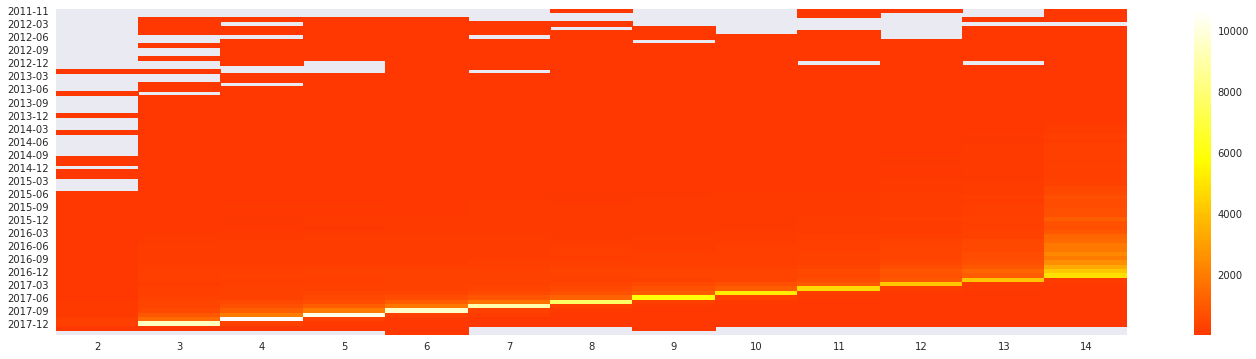

In [62]:
df_fam.sort_index(axis=0, inplace=True)
plt.figure(figsize=(24, 6))
sns.heatmap(df_fam, cmap='hot', center = 1000, vmin=10)
# sns.heatmap(df, vmax=10, vmin=-10, center=0)

2
6.37713121
-8.43352356


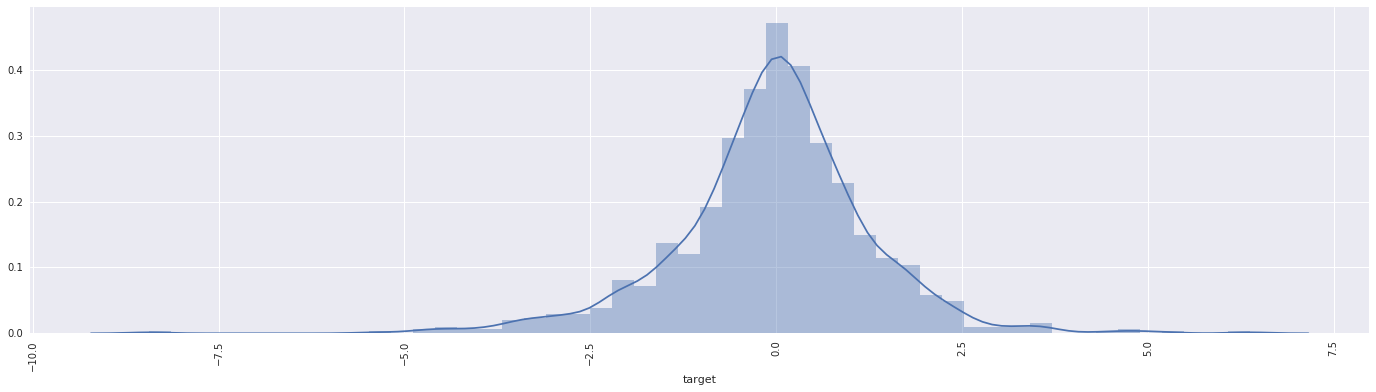

3
8.38920949
-9.33382952


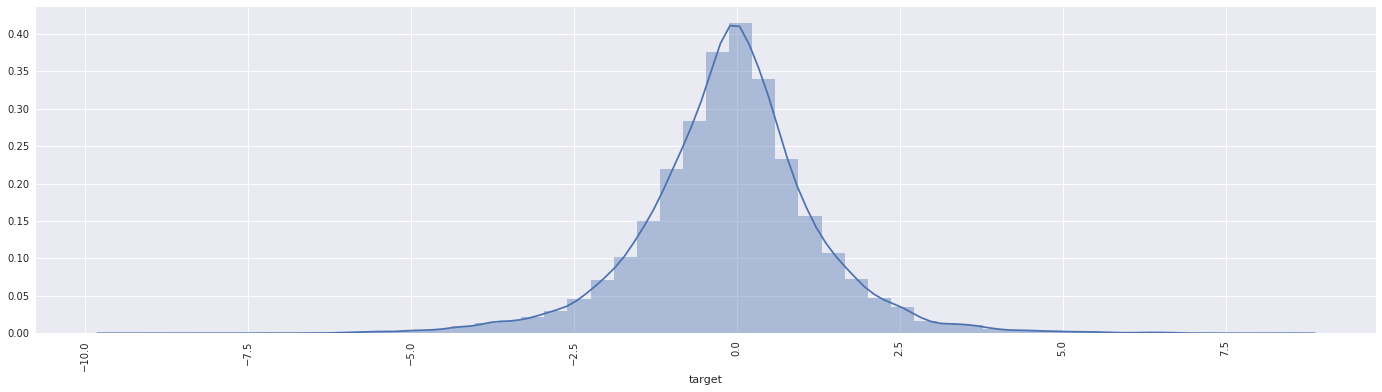

4
12.97039354
-33.21928095


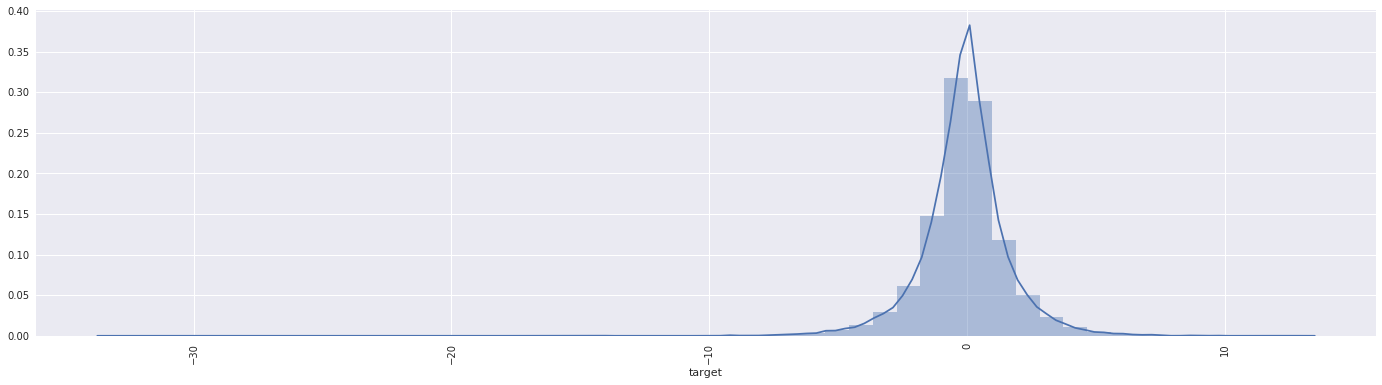

5
12.44656641
-33.21928095


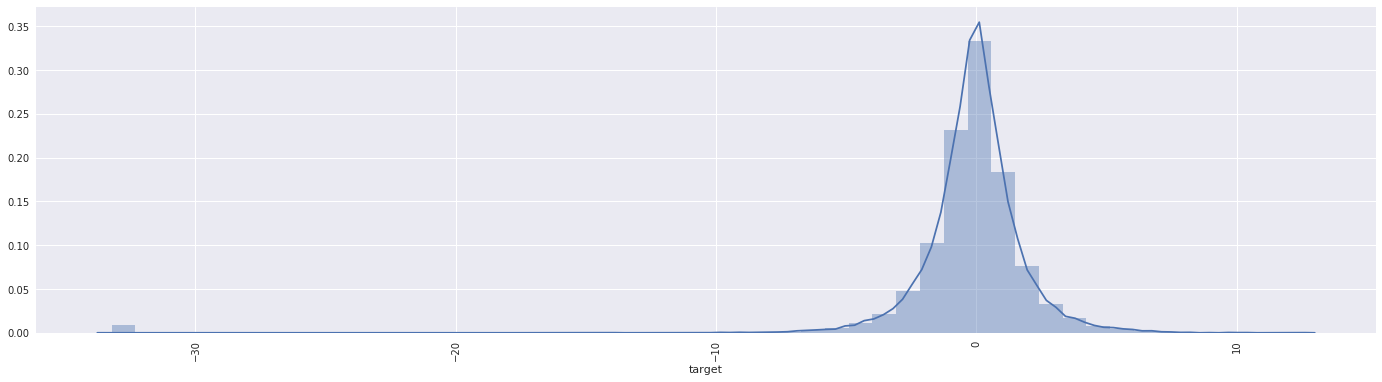

6
13.60987129
-33.21928095


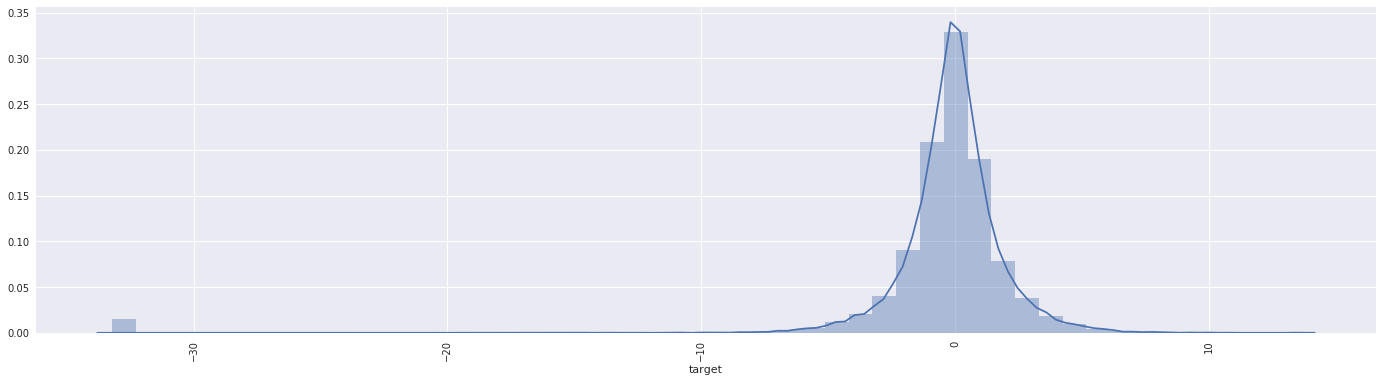

7
14.85516048
-33.21928095


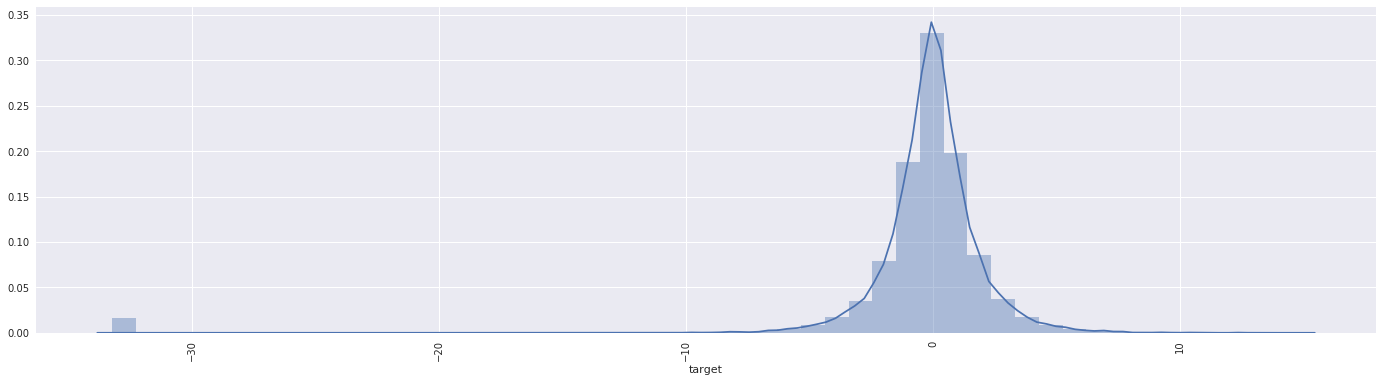

8
13.31061278
-33.21928095


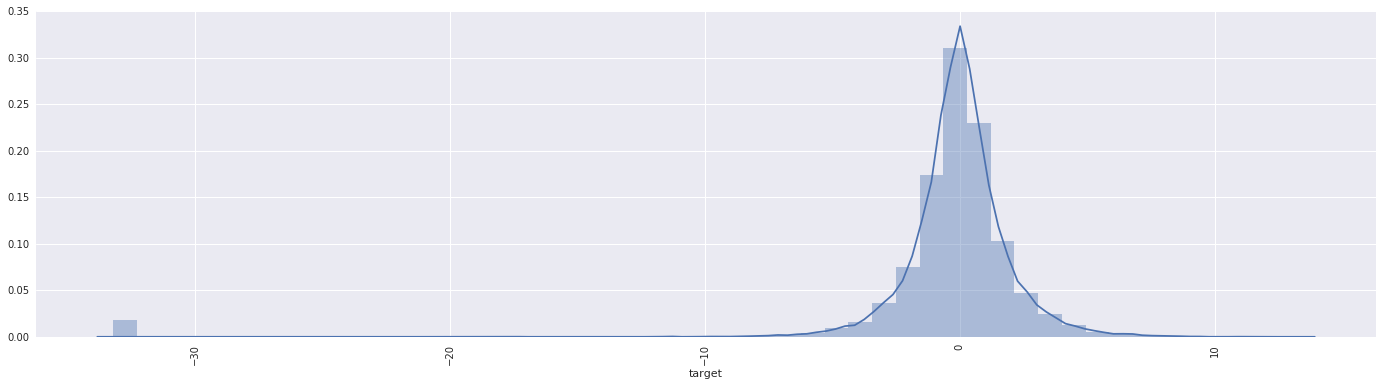

9
17.9650684
-33.21928095


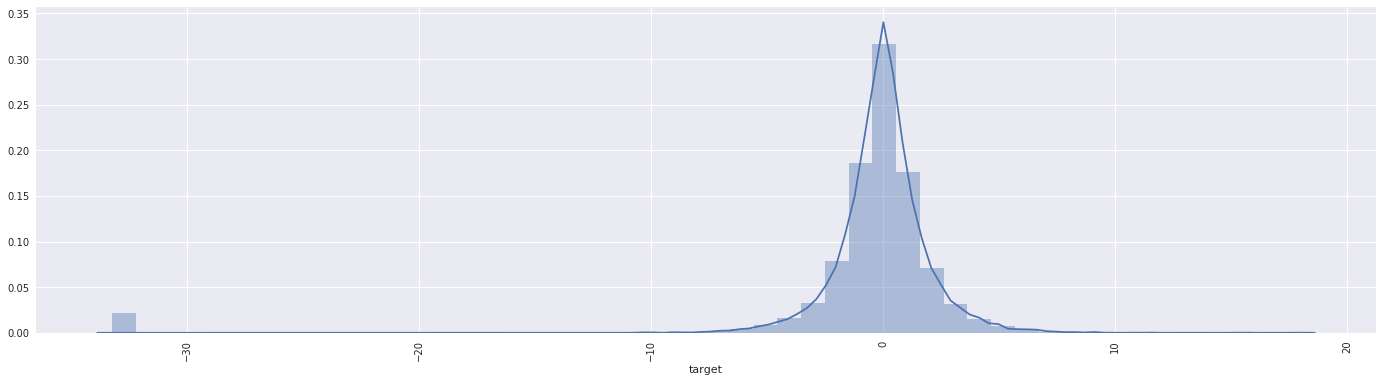

10
11.31566472
-33.21928095


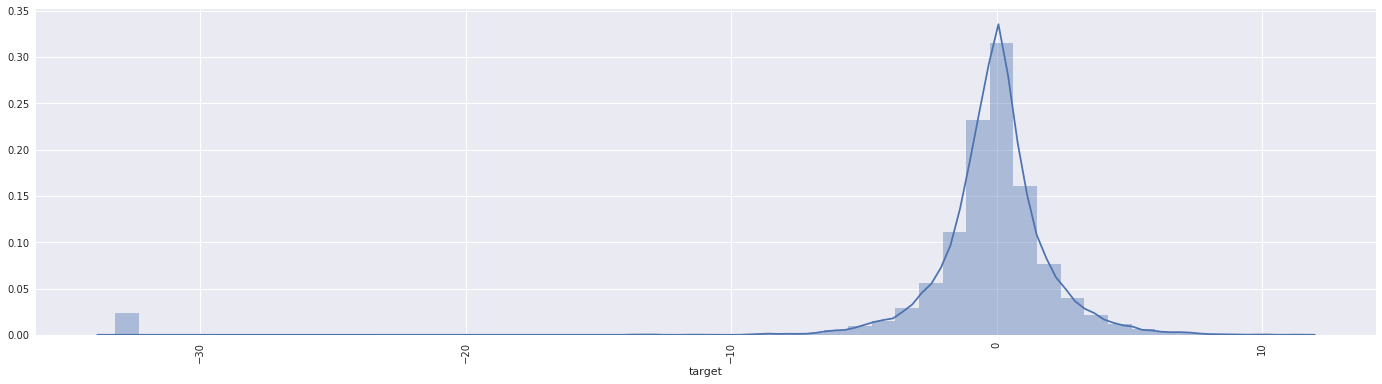

11
15.99445509
-33.21928095


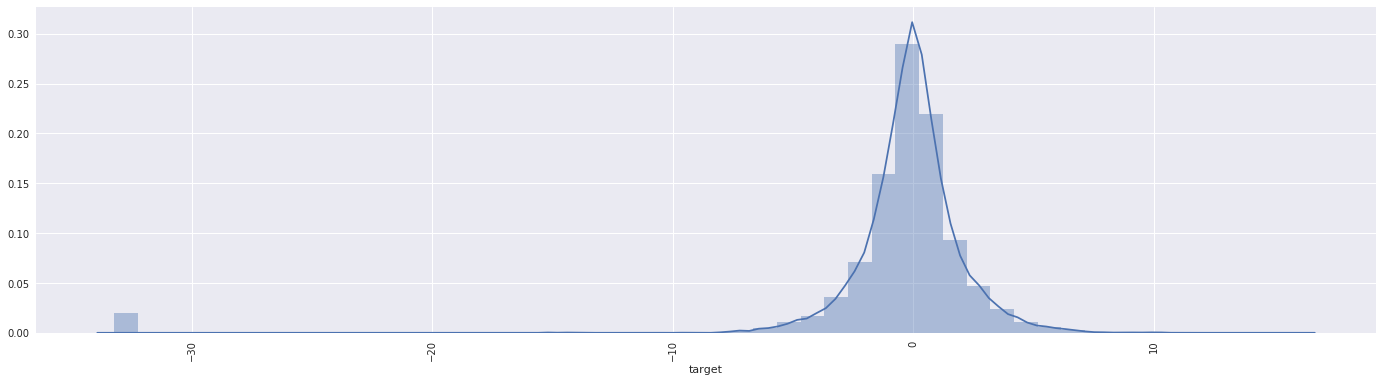

12
12.74399286
-33.21928095


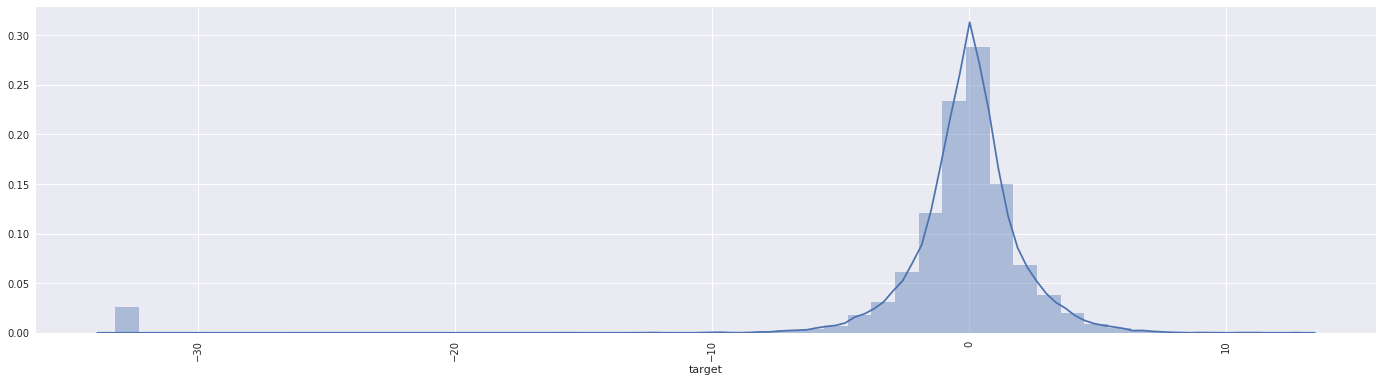

13
15.29462075
-33.21928095


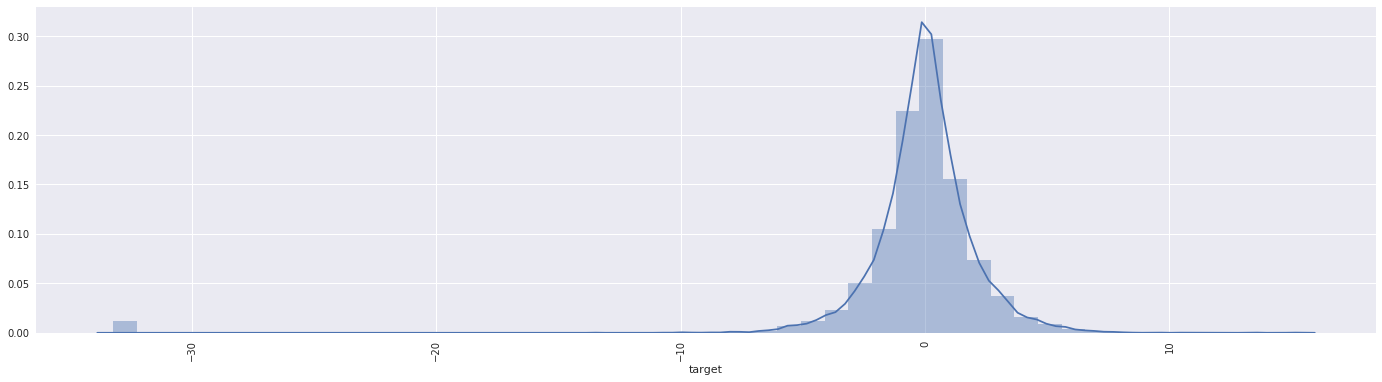

14
17.67571588
-33.21928095


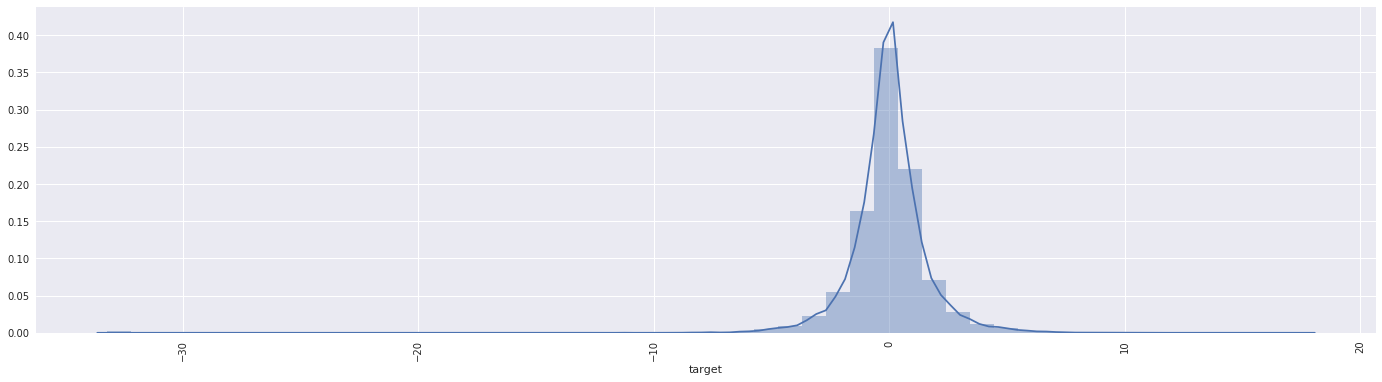

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
term_list = sorted(list(df_train['hist_personal_term'].value_counts().index))
df = df_train

for i in term_list:
    tmp = df[df['hist_personal_term']==i]
    
    print(f"{i}")
    print(tmp[target].max())
    print(tmp[target].min())
    plt.figure(figsize=(24, 6))
    sns.distplot(a=tmp['target'])
    plt.xticks(rotation=90)
    plt.show()